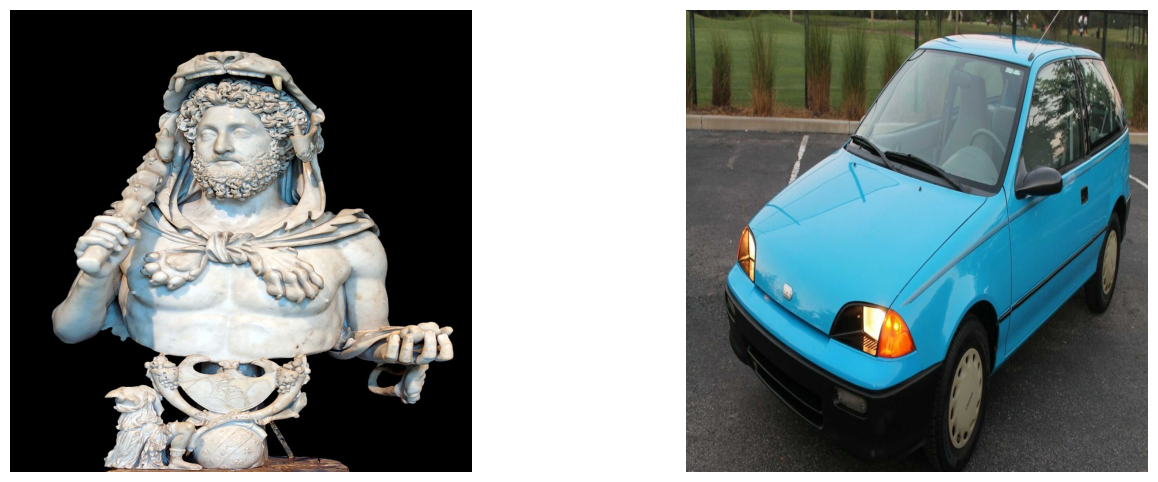

In [1]:
# Load libraries
import numpy as np
import scipy as sp
import scipy.stats as sp
import statsmodels.api as sm
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

commodus = "/home/jovyan/ECON_143/Commodus.jpg"
metro = "/home/jovyan/ECON_143/metro.jpg"
img1 = mpimg.imread(commodus)
img2 = mpimg.imread(metro)

# Create a figure with two subplots side by side
plt.figure(figsize=(16, 6))  # Adjust total figure size as needed

# Display first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img1, extent=[4, 4.50, 5, 5.50])  # Adjust extent if necessary
plt.axis('off')  # Turn off axis for the first image

# Display second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(img2, extent=[4, 4.50, 5, 5.50])  # Adjust extent if necessary
plt.axis('off')  # Turn off axis for the second image

# Show the plot
plt.show()

### Introduction: Bayesian Emperors and Fuel Economy
Emperor Commodus spends his Friday evenings at the colosseum. A common event in this historical fiction is where one of the Emperor's guards duels challengers. Of course, as Emperor, Commodus gets to choose who faces off against his guard. He chooses from challengers hailing from different locations, different combat classes, and different experience levels. Commodus dillegently records the outcome of each fight in his journal, as well as the characteristics of the challenger, adding each observation to his information set, $$I_t = I_{t-1} \cup f_t$$ Where $f_t$ denotes the details of the fight in time period $t$, which is measured discretely. Commodus, depending on how he is feeling that day from other events independent of the colosseum event, has different moods. These include: curious, cruel, and greedy. He bases his decision on who to pick based on his mood, as well as the information set which inform his decision on what choice he believes will most likely satisfy his mood. This project will use tools from the Bernoulli Bandits and Thompson Sampling lessons to model the Emperor's mood and subseqent choices of challenger. 

### Data and Assumptions
The data set for the latter fuel economy exploration is from data from 1998 to 2008 from 38 different car models, sourced from fueleconomy.gov. 

Some key assumptions for this first setting are that each guard is homogenous across a vector of characteristics, and that each challenger, once their location, class, and experience are determined, are also homogenous across all other characteristics. Population chances for success are known and specified below. Information on the total victories in each simulation, challenger picked, and other summary statistics are returned. 

### Challenger Characteristics
There are two locations someone can hail from, Gaul and Britannia. There are two combat classes, light and heavy. Finally, there are three different experience levels: novice, adept, and expert. So in total, there are 12 unique combinations of characteristics. Therefore, this analysis will have a 12 armed bandit. 

In [2]:
# Defining the chance of victory for each challenger, there are two different regions that challengers hail
victory_chance = [0.45, 0.60, 0.80, 0.55, 0.65, 0.85, 0.20, 0.30, 0.40, 0.25, 0.35, 0.50]  # Population success rates for each type of fighter
T = 1000                         # Number of fights to simulate
S = 1000                      # Number of Simulations 

### Curious Emperor 

When Commodus is in an exploratory mood, he we will observe the pool of challenger applicants, and select one uniformly at random. This is a pure exploration algorithm.

In [3]:
S = 1000              # Number of Simulations 
def curiousemperor(victory_chance, T, seed):
    J = len(victory_chance)

    #Number of successes (victories) and failures initialization
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    
    rnd = np.random.RandomState(seed)

    machines = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))
    
    for t in range(T):
        machine = rnd.choice(J)
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t

        machines[t,:] = np.eye(1, J, k=machine)
        
        E_victory_p[t,:] = (S + 1) / (S + F + 2)
        V_victory_p[t,:] = (S + 1) * (F + 1) / (((S + F + 2) ** 2) * (S + F + 3))

        total_victories = np.sum(S)

    return [total_victories, machines, E_victory_p, V_victory_p, S, F]

# Initialize variables for accumulating results
total_victories_curious = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = curiousemperor(victory_chance, T, seed)
    total_victories_curious.append(total_victories)

average_total_victories_curious = np.mean(total_victories_curious)

### Greedy Emperor

When Commodus is in a 'greedy' mood, he we will observe the pool of challenger applicants, and select one that he believes will have the best chance of winning, based on his information set. This algorithm will always pick the arm that is percieved to be the "best", and is a pure exploitation algorithm. 

In [4]:
S = 1000                      # Number of Simulations 
def greedyemperor(victory_chance, T, seed):
    J = len(victory_chance)
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    rnd = np.random.RandomState(seed)

    machines = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))
    
    for t in range(T):
        machine = np.argmax((S+1)/(S+F+2))
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t
        
        machines[t,:] = np.eye(1, J, k=machine)
        
        E_victory_p[t,:] = (S + 1) / (S + F + 2)
        V_victory_p[t,:] = (S + 1) * (F + 1) / (((S + F + 2) ** 2) * (S + F + 3))

        total_victories = np.sum(S)

    return [total_victories, machines, E_victory_p, V_victory_p, S, F]
total_victories_greedy = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = greedyemperor(victory_chance, T, seed)
    total_victories_greedy.append(total_victories)
    
average_total_victories_greedy = np.mean(total_victories_greedy)

### Cruel Emperor

When Commodus is in a 'cruel' mood, he we will observe the pool of challenger applicants, and select one that he believes will have the worst chance of winning.

In [5]:
S = 1000                      # Number of Simulations 
def cruelemperor(victory_chance, T, seed):
    J = len(victory_chance)
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    rnd = np.random.RandomState(seed)

    machines = np.zeros((T, J))
    E_victory_p = np.zeros((T, J))
    V_victory_p = np.zeros((T, J))
    
    for t in range(T):
        machine = np.argmin((S+1)/(S+F+2))  # Choose the machine with the worst chance
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t
        total_victories = np.sum(S)  # Calculate total victories after all time steps

        machines[t,:] = np.eye(1, J, k=machine)
        
        E_victory_p[t,:] = (S + 1) / (S + F + 2)
        V_victory_p[t,:] = (S + 1) * (F + 1) / (((S + F + 2) ** 2) * (S + F + 3))


    return [machines, E_victory_p, V_victory_p, total_victories, S, F]

# Initialize variables for accumulating results
total_victories_cruel = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = cruelemperor(victory_chance, T, seed)
    total_victories_cruel.append(total_victories)

average_total_victories_cruel = np.mean(total_victories_cruel)

In [6]:
[total_victories, machines, E_victory_p, V_victory_p, S, F] = cruelemperor(victory_chance, T, seed=361)

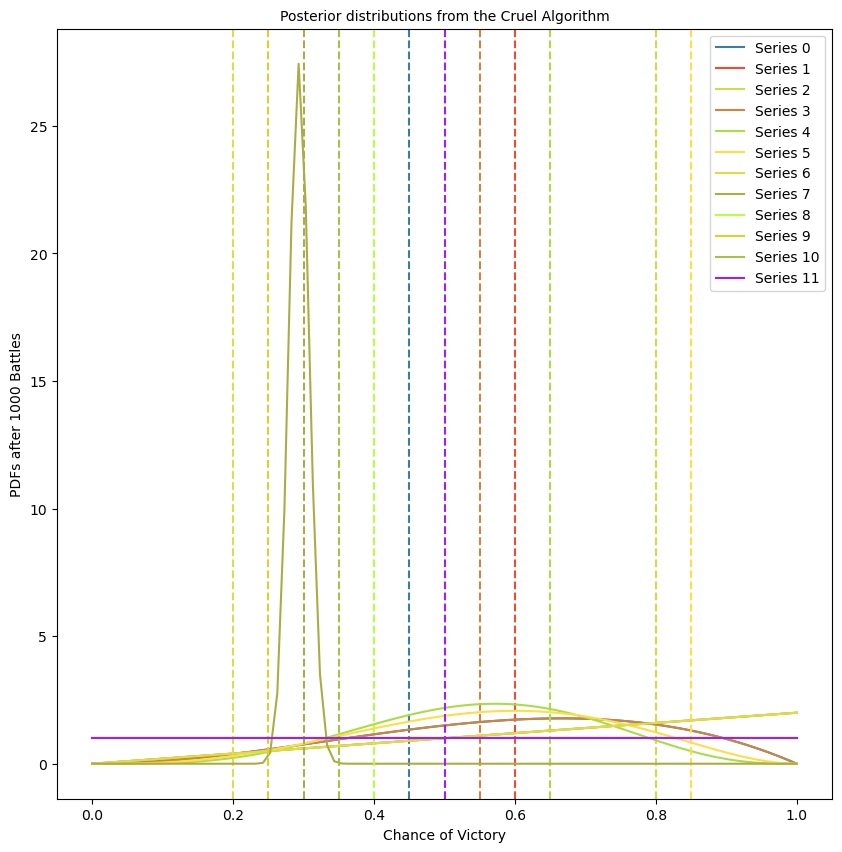

In [7]:
# Define colors for different series
colors = ['#3B7EA1', '#ED4E33', '#CFDD45', '#CD853F', '#AADD45', '#FFDD45',
          '#DDDD45', '#AAAD45', '#BAFD45', '#DDCF30', '#AABF45', '#A020F0']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Generate data
a = np.linspace(0, 1, num=100)

# Plot each series dynamically
for i in range(len(S)):
    plt.plot(a, sp.beta.pdf(a, S[i]+1, F[i]+1), color=colors[i], label=f'Series {i}')
    plt.axvline(x=victory_chance[i], color=colors[i], linestyle='--')

# Set titles and labels
ax.set_title('Posterior distributions from the Cruel Algorithm', fontsize=10)
ax.set_xlabel('Chance of Victory')
ax.set_ylabel('PDFs after 1000 Battles')

plt.legend()
plt.show()

### A New Development 

One of the Emperor's scribes, Gaius, has recently informed him of a new technique for trying to balance exploration and exploitation -- Thompson Sampling. This technique balances exploitation and exploration by randomly sampling from the posterior distributions and choosing the argument that maximizes the probability of success based on that random sample. This allows Commodus to keep his mind open to other challengers that have a lower posterior mean, while still taking advantage of the fact that others have higher chances of winning according to his information set.  

In [8]:
S = 1000                      # Number of Simulations 
def thompsonemperor(victory_chance, T, seed=476):
    #Intitializing key variables
    J = len(victory_chance)                                 

    #Setting successes and failures to 0s to start
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)

    rnd = np.random.RandomState(seed)

    machines  = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))

    for t in range(T):
        #Drawing from each arm
        victory_chance_t   = rnd.beta(S + 1, F + 1) 
        #Choosing best one in that particular round
        machine   = np.argmax(victory_chance_t)      
        #Determining success
        success_t = rnd.binomial(1,victory_chance[machine]) 
        #Updating success and failures
        S[machine] += success_t                    
        F[machine] += 1 - success_t                

        machines[t,:] = np.eye(1,J,k=machine)

        #updating and caluclating mean and variance for chosen arm
        E_victory_p[t,:] = (S + 1)/(S + F + 2)
        V_victory_p[t,:] = (S + 1)*(F + 1)/(((S+F+2)**2)*(S+F+3))

        total_victories = np.sum(S)
    
    return [total_victories, machines, E_victory_p, V_victory_p, S, F] 
    
total_victories_thompson = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = thompsonemperor(victory_chance, T, seed)
    total_victories_thompson.append(total_victories)

average_total_victories_thompson = np.mean(total_victories_thompson)

### Maximizing Cruelty with Thompson Sampling?

Unfortunately, Commodus utilizes this new technique for choosing challengers regardless if he is in a greedy or cruel mood. So he adapts the approach to choose the challenger he believes has the least likely chance of winning.

In [9]:
S = 1000                      # Number of Simulations 
def thompsonemperorcruel(victory_chance, T, seed=476):
    #Intitializing key variables
    J = len(victory_chance)                                 

    #Setting successes and failures to 0s to start
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)

    rnd = np.random.RandomState(seed)

    machines  = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))

    for t in range(T):
        #Drawing from each arm
        victory_chance_t   = rnd.beta(S + 1, F + 1) 
        #Choosing best one in that particular round
        machine   = np.argmin(victory_chance_t)      
        #Determining success
        success_t = rnd.binomial(1,victory_chance[machine]) 
        #Updating success and failures
        S[machine] += success_t                    
        F[machine] += 1 - success_t                

        machines[t,:] = np.eye(1,J,k=machine)

        #updating and caluclating mean and variance for chosen arm
        E_victory_p[t,:] = (S + 1)/(S + F + 2)
        V_victory_p[t,:] = (S + 1)*(F + 1)/(((S+F+2)**2)*(S+F+3))

        total_victories = np.sum(S)
    
    return [total_victories, machines, E_victory_p, V_victory_p, S, F] 
    
total_victories_thompsoncruel = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = thompsonemperorcruel(victory_chance, T, seed)
    total_victories_thompsoncruel.append(total_victories)

average_total_victories_thompsoncruel = np.mean(total_victories_thompsoncruel)

In [10]:
comparison_df = pd.DataFrame({
    'Algorithm (Emperor Temprement)': ['Thompson Sampling Greedy','Thompson Sampling Cruel', 'Greedy', 'Curious', "Cruel"],
    'Average Total Victories Per Night (Out of 1000)': [
        average_total_victories_thompson,
        average_total_victories_thompsoncruel,
        average_total_victories_greedy,
        average_total_victories_curious,
        average_total_victories_cruel
    ]
})

comparison_df

,Algorithm (Emperor Temprement),Average Total Victories Per Night (Out of 1000)
0,Thompson Sampling Greedy,803.435000
1,Thompson Sampling Cruel,257.732000
2,Greedy,718.669000
3,Curious,491.618000
4,Cruel,0.083333


In [11]:
[total_victories, machines, E_victory_p, V_victory_p, S, F] = thompsonemperor(victory_chance, T, seed=361)

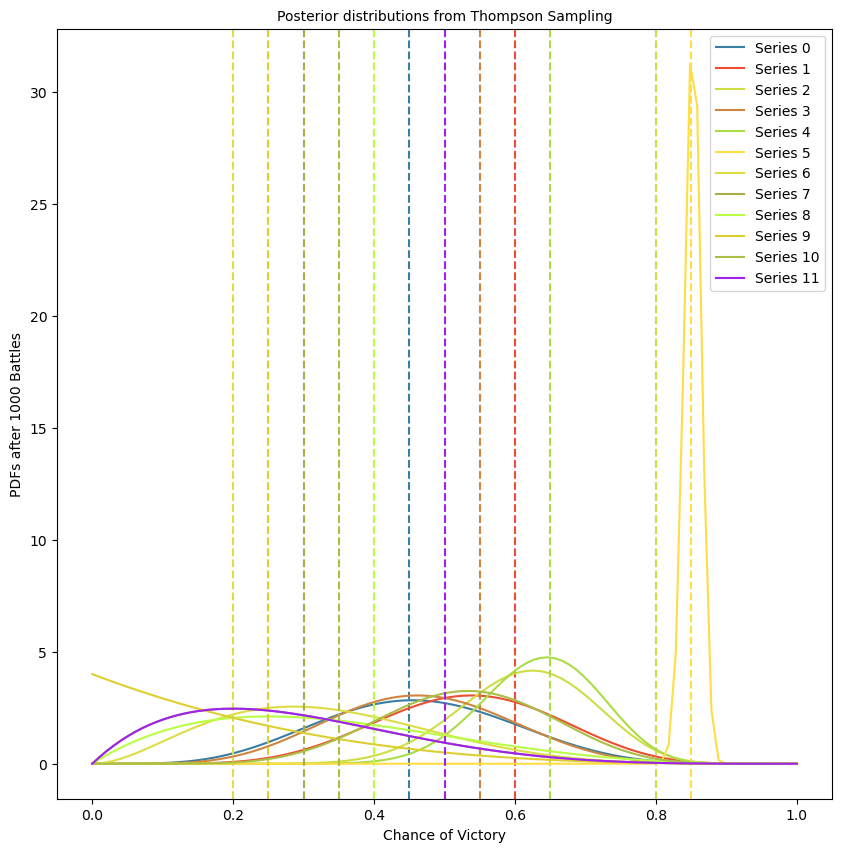

In [12]:
# Define colors for different series
colors = ['#3B7EA1', '#ED4E33', '#CFDD45', '#CD853F', '#AADD45', '#FFDD45',
          '#DDDD45', '#AAAD45', '#BAFD45', '#DDCF30', '#AABF45', '#A020F0']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Generate data
a = np.linspace(0, 1, num=100)

# Plot each series dynamically
for i in range(len(S)):
    plt.plot(a, sp.beta.pdf(a, S[i]+1, F[i]+1), color=colors[i], label=f'Series {i}')
    plt.axvline(x=victory_chance[i], color=colors[i], linestyle='--')

# Set titles and labels
ax.set_title('Posterior distributions from Thompson Sampling', fontsize=10)
ax.set_xlabel('Chance of Victory')
ax.set_ylabel('PDFs after 1000 Battles')

plt.legend()
plt.show()

In [13]:
[total_victories, machines, E_victory_p, V_victory_p, S, F] = thompsonemperorcruel(victory_chance, T, seed=361)

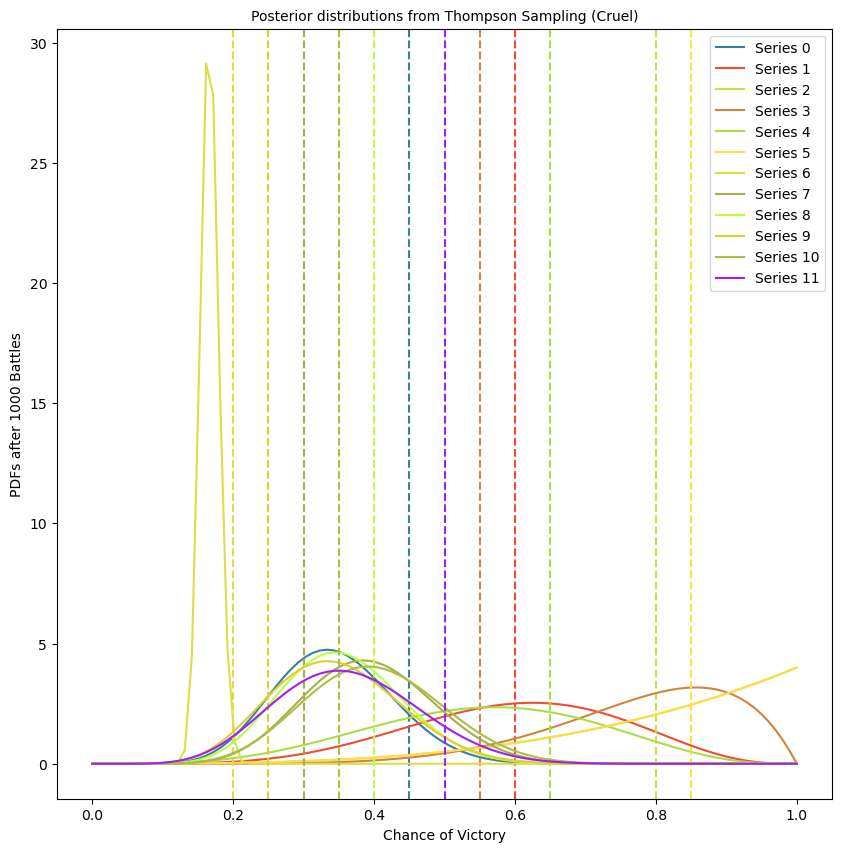

In [14]:
# Define colors for different series
colors = ['#3B7EA1', '#ED4E33', '#CFDD45', '#CD853F', '#AADD45', '#FFDD45',
          '#DDDD45', '#AAAD45', '#BAFD45', '#DDCF30', '#AABF45', '#A020F0']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Generate data
a = np.linspace(0, 1, num=100)

# Plot each series dynamically
for i in range(len(S)):
    plt.plot(a, sp.beta.pdf(a, S[i]+1, F[i]+1), color=colors[i], label=f'Series {i}')
    plt.axvline(x=victory_chance[i], color=colors[i], linestyle='--')

# Set titles and labels
ax.set_title('Posterior distributions from Thompson Sampling (Cruel)', fontsize=10)
ax.set_xlabel('Chance of Victory')
ax.set_ylabel('PDFs after 1000 Battles')

plt.legend()
plt.show()


### Scribe Rivalry, Epsilon-Greedy Algorithm

Commodus is appraoched by his other scribe, Horace, who has observed him impliment the Thompson Sampling strategy to both maximize and minimize risk. Horace and Gaius have a healthy rivalry, and he proposes a different form of learning, epsilon-greedy. This exploration is inspired by the material on this subject from the short introduction of it here : https://stanford-cs221.github.io/autumn2020-extra/modules/mdps/epsilon-greedy.pdf

The Epsilon-Greedy Method differs from Thompson Sampling as it more explicity sets a tradeoff between exploration and exploitation. Letting $\epsilon \in [0,1]$ be the chance that instead of choosing the arm with the highest percieved chance of success in time period $t$, another arm is chosen uniformly at random. For example, if we let $\epsilon = 0.10$, 10 percent of the time, Commodus, rather than choosing the fighter he believes will best satisfy his temprement, will choose one randomly. Where $ 1 - \epsilon$ of the time he will engage in the previously defined greedy algorithm.

In [15]:
S = 1000                      # Number of Simulations 
def epsilonemperor(victory_chance, T, seed):
    J = len(victory_chance)

    #Number of successes (victories) and failures initialization
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    
    rnd = np.random.RandomState(seed)

    machines = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))
    
    for t in range(T):
        # Decide whether to explore or exploit
        if rnd.uniform() < 0.10:  # 10% of the time, explore
            machine = rnd.choice(J)
        else:  # 90% of the time, exploit
            machine = np.argmax((S + 1) / (S + F + 2))
        
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t

        machines[t,:] = np.eye(1, J, k=machine)
        
        E_victory_p[t,:] = (S + 1) / (S + F + 2)
        V_victory_p[t,:] = (S + 1) * (F + 1) / (((S + F + 2) ** 2) * (S + F + 3))

        total_victories = np.sum(S)

    return [total_victories, machines, E_victory_p, V_victory_p, S, F]

total_victories_epsilon = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = epsilonemperor(victory_chance, T, seed)
    total_victories_epsilon.append(total_victories)

average_total_victories_epsilon = np.mean(total_victories_epsilon)

In [16]:
[total_victories, machines, E_victory_p, V_victory_p, S, F] = epsilonemperor(victory_chance, T, seed=361)

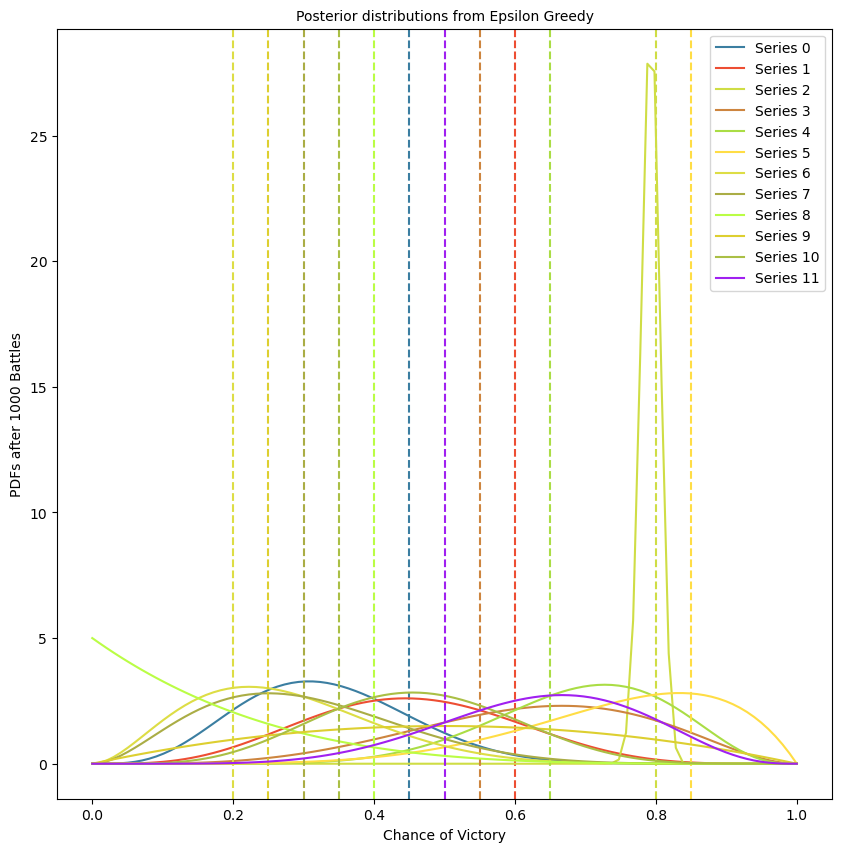

In [17]:
# Define colors for different series
colors = ['#3B7EA1', '#ED4E33', '#CFDD45', '#CD853F', '#AADD45', '#FFDD45',
          '#DDDD45', '#AAAD45', '#BAFD45', '#DDCF30', '#AABF45', '#A020F0']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Generate data
a = np.linspace(0, 1, num=100)

# Plot each series dynamically
for i in range(len(S)):
    plt.plot(a, sp.beta.pdf(a, S[i]+1, F[i]+1), color=colors[i], label=f'Series {i}')
    plt.axvline(x=victory_chance[i], color=colors[i], linestyle='--')

# Set titles and labels
ax.set_title('Posterior distributions from Epsilon Greedy', fontsize=10)
ax.set_xlabel('Chance of Victory')
ax.set_ylabel('PDFs after 1000 Battles')

plt.legend()
plt.show()

In [18]:
rivalry_df = pd.DataFrame({
    'Algorithm (Emperor Temprement)': ['Thompson Sampling', 'Epsilon-Greedy (epsilon = 0.10)'],
    'Average Total Victories': [average_total_victories_thompson, average_total_victories_epsilon]
})

rivalry_df

,Algorithm (Emperor Temprement),Average Total Victories
0,Thompson Sampling,803.435
1,Epsilon-Greedy (epsilon = 0.10),771.674


In [33]:
S = 1000
T = 1000
def epsilonemperormodified(victory_chance, T, seed):
    J = len(victory_chance)

    #Number of successes (victories) and failures initialization
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    
    rnd = np.random.RandomState(seed)
    epsilon = 1
    machines = np.zeros((T,J))
    E_victory_p = np.zeros((T,J))
    V_victory_p = np.zeros((T,J))
    
    for t in range(T):
        # Decide whether to explore or exploit
        if rnd.uniform() < (epsilon / (t + 1)):  # 10% of the time, explore
            machine = rnd.choice(J)
        else:  # 90% of the time, exploit
            machine = np.argmax((S + 1) / (S + F + 2))
        
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t

        machines[t,:] = np.eye(1, J, k=machine)
        
        E_victory_p[t,:] = (S + 1) / (S + F + 2)
        V_victory_p[t,:] = (S + 1) * (F + 1) / (((S + F + 2) ** 2) * (S + F + 3))

        total_victories = np.sum(S)

    return [total_victories, machines, E_victory_p, V_victory_p, S, F]

total_victories_epsilon_modified = []

for s in range(S):
    seed = 476 + s  # Change seed for each simulation
    [total_victories, machines, E_victory_p, V_victory_p, S, F] = epsilonemperormodified(victory_chance, T, seed)
    total_victories_epsilon_modified.append(total_victories)

average_total_victories_epsilon_modified = np.mean(total_victories_epsilon_modified)

In [34]:
[total_victories, machines, E_victory_p, V_victory_p, S, F] = epsilonemperormodified(victory_chance, T, seed=361)

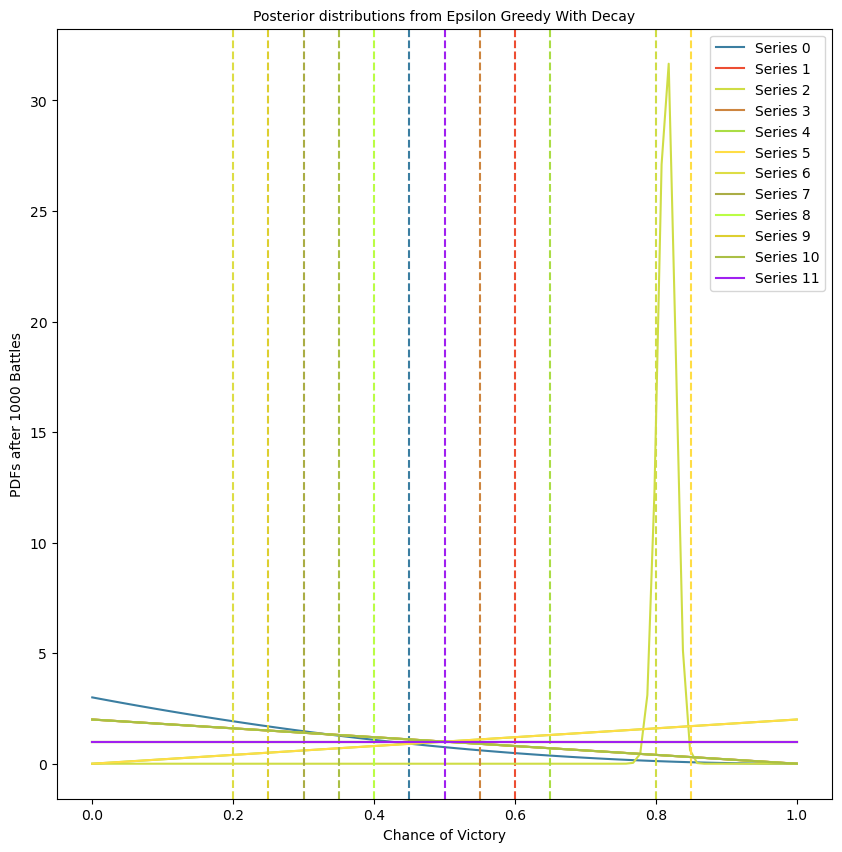

In [35]:
# Define colors for different series
colors = ['#3B7EA1', '#ED4E33', '#CFDD45', '#CD853F', '#AADD45', '#FFDD45',
          '#DDDD45', '#AAAD45', '#BAFD45', '#DDCF30', '#AABF45', '#A020F0']

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Generate data
a = np.linspace(0, 1, num=100)

# Plot each series dynamically
for i in range(len(S)):
    plt.plot(a, sp.beta.pdf(a, S[i]+1, F[i]+1), color=colors[i], label=f'Series {i}')
    plt.axvline(x=victory_chance[i], color=colors[i], linestyle='--')

# Set titles and labels
ax.set_title('Posterior distributions from Epsilon Greedy With Decay', fontsize=10)
ax.set_xlabel('Chance of Victory')
ax.set_ylabel('PDFs after 1000 Battles')

plt.legend()
plt.show()

In [22]:
comparison_df = pd.DataFrame({
    'Algorithm (Emperor Temprement)': ['Thompson Sampling Greedy','Thompson Sampling Cruel', 'Greedy', 'Curious', "Cruel","Epsilon-Greedy Fixed",'Epsilon-Greedy Decay'],
    'Average Total Victories Per Night (Out of 1000)': [
        average_total_victories_thompson,
        average_total_victories_thompsoncruel,
        average_total_victories_greedy,
        average_total_victories_curious,
        average_total_victories_cruel, 
        average_total_victories_epsilon,
        average_total_victories_epsilon_modified
    ]
})

comparison_df

,Algorithm (Emperor Temprement),Average Total Victories Per Night (Out of 1000)
0,Thompson Sampling Greedy,803.435000
1,Thompson Sampling Cruel,257.732000
2,Greedy,718.669000
3,Curious,491.618000
4,Cruel,0.083333
5,Epsilon-Greedy Fixed,771.674000
6,Epsilon-Greedy Decay,759.767000


Surpisingly, the Epsilon Greedy with the Decaying Epsilon performs slightly worse than the Epsilon Greedy with a fixed epsilon. Although, they both perform better than a pure exploitation algorithm, and worse than Thompson Sampling. 

### Interpretation and Discussion

Commodus and his scribes have now at their disposal a range of alogirthims to choose from to learn which fighter has the best and worst chance of success, which are both important to know for Commodus depending on his temprement. From the figures displaying the posterior distributions of each fighter's chance of winning, Thompson Sampling does a good job at identifing which is the best and worse arm, and at estimating the true value of that arm's chance of success.

However, the distributions for the other arms, due to the lack of draws, are not very informative. This is especially the case when the arm is further and further away from the optimal arm. This makes sense, as it becomes less and less likely for that arm to be chosen, keeping the variance of the posterior disctribution relatively large due to the fact that we assume a uniform prior on all arms. This was not the case in problem set 2, where the three arms all had clearly defined normally distributed posterior means. This could be because in that problem set, there was only three arms. Here there are 12, and some of them are quite close together in terms of what their population chance of success is. There are 1000 simulations here, and 1000 simulations in the problem set. Perhaps as the number of arms increases, the number of simulations must also increase in order to get more precise estimates on the distributions of the non-optimal arms. This could be a possible extension, comparing posterior distributions of many armed bandits with a different number of simulations. It's also curious to me the relationship in general between simualtions suggested for this analysis based on the number of arms. My intuition is that the number of simulations required to get information about posterior distributions increases non-linearly with the number of arms. 

On the other hand, compared with the Epsilon-Greedy algorithm, it's apparent where, in this case at least, the two algorithms are better and worse. From the posterior distributions of the Epsilon-Greedy algorithm with a fixed epsilon, we have a decent amount of information about arms that are even non-optimal and far away from being optimal. This is because there is always an epsilon percent chance that we will instead of exploiting, explore and choose uniformly randomly among the 11 non-optimal arms. This again lets us get decent estiamtes of every arm, but again average the number of wins across all simulations with this method is less than Thompson Sampling. Moreover, both Epsilon-Greedy algorithms incorrectly identified the second best arm to be the best arm, i.e the arm that was chosen the most was only the second best arm. 

Something commented on in the cell above is the fact that the Epsilon-Greedy Algorithm with a decaying epsilon performed worse than the one with a fixed epsilon. Here is another opportunity to expand on this exploration, what is the best decay schedule? In this analysis I used a relatively simple decay of just Setting Epsilon equal to 1, and dividing by $t+1$. Upon reflection, it makes sense that an Epsilon-Greedy with this decay scheudle might not be better than one with a more persisent element of exploration. If $E$ denotes the epsilon-greedy algorithm, and $G$ denotes the pure exploitation algorithm, $$lim_{t \rightarrow \infty}\frac{\epsilon}{1+t} \rightarrow 0 \Rightarrow E \rightarrow G$$

As the number of trials increase, epsilon approaches zero, and the algorithm approaches the standard greedy, pure exploitation algorithm. Pehraps a decay schedule with a slower rate of convergence would perform better than one that converges relatively quickly? As seen earlier, the pure greedy algorithm performs worse than both Epsilon-Greedy algorithms and Thompson Sampling. It makes sense that more weight should be given to exploration if this is the case. Another consequence of epsilon converging quickly is that, not only do we not have the best arm chosen, but we also don't have good information on the other arms that the algorithm decided not to exploit. So out of the three algorithms, the decaying epsilon performs the worse both in the exploitation and exploration. 

This also brings up the question of what the goal of bandit algorithms are, and this might change which algorithm to use. For example, does Commodus care about who is the best and worst fighter? Or does he care about estimating the true success rate of each fighter? This, I imagine, would inform the decay schedule of an Epsilon-Greedy algorthim.

### Empirical Application

What follows is a brief empirical application on a data set of cars. Each manufacturer produces different car models, each with various characteristics. One characteristic is miles per gallon. One way that we can apply the algorithms developed earlier is by first setting a victory condition. For the purpose of this exploration, I've chosen to calculate median MPG of all the models, and get probabilities for how often a manufacturer, picked at random, has a car in the data set that gets better gas milleage than the median. This is done by counting the cardinality of $A$, the event that a randomly chosen car exceeds the median highway gas millage, we have $$P(A) = \frac{|A|}{|\Omega|}$$ where $\Omega$ is the total sample space. 

The algorithms will attempt to identify the "arm", in this case, the manufacturer, that is the best at acheiving this goal. This empirical application has some interesting quirks that hopefully reveal something else about the algorithms previoulsy exlpored, now in a real world setting.

In [23]:
cars = '/home/jovyan/ECON_143/cars2.csv'

cars = pd.read_csv(cars)
cars.head()

,Unnamed: 0,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,1,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,2,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,3,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,4,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,5,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


In [24]:
# Step 1: Calculate the median highway mileage to define the victory condition
median_hwy = cars['hwy'].median()

# Step 2: Calculate the probability of victory for each manufacturer
# Define a victory as achieving higher than the median highway mileage
victory_probabilities = cars.groupby('manufacturer')['hwy'].apply(lambda x: (x > median_hwy).mean())

# Show the calculated median highway mileage and victory probabilities for each manufacturer
median_hwy, victory_probabilities

(24.0,
 manufacturer
 audi          0.888889
 chevrolet     0.421053
 dodge         0.000000
 ford          0.120000
 honda         1.000000
 hyundai       0.785714
 jeep          0.000000
 land rover    0.000000
 lincoln       0.000000
 mercury       0.000000
 nissan        0.692308
 pontiac       1.000000
 subaru        0.857143
 toyota        0.558824
 volkswagen    0.888889
 Name: hwy, dtype: float64)

### Empirical Setting Quirks

Something that is immediately clear is that the arm probabilities are much different that the challenger victory probabilities. There are several arms that actually have zero chance of acheiving a victory state, and multiple arms that have a one hundred percent chance of having their car exceed the median MPG. 

In [25]:
# Simulation parameters
T = 100  # Trials per simulation
S = 100  # Number of simulations

# Convert victory probabilities to an array
victory_chances = victory_probabilities.values

# Define the epsilon-modified algorithm
def epsilongreedycars(victory_chance, T, seed):
    J = len(victory_chance)
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    rnd = np.random.RandomState(seed)
    epsilon = .10 
    total_victories = []

    for t in range(T):
        # Explore or exploit decision
        if rnd.uniform() < epsilon :
            machine = rnd.choice(J)
        else:
            machine = np.argmax((S + 1) / (S + F + 2))
        
        # Simulate outcome
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t
        total_victories.append(np.sum(S))

    return total_victories[-1]

In [26]:
# Define the Thompson Sampling algorithm
def thompsoncars(victory_chance, T, seed):
    J = len(victory_chance)
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    rnd = np.random.RandomState(seed)
    total_victories = []

    for t in range(T):
        # Thompson Sampling decision
        victory_chance_t = rnd.beta(S + 1, F + 1)
        machine = np.argmax(victory_chance_t)
        
        # Simulate outcome
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t
        total_victories.append(np.sum(S))

    return total_victories[-1]

# Running simulations for both algorithms
total_mpg_victories_epsilon = [epsilongreedycars(victory_chances, T, seed=476 + s) for s in range(S)]
total_mpg_victories_thompson = [thompsoncars(victory_chances, T, seed=476 + s) for s in range(S)]

# Calculate the average total victories for both algorithms
average_total_mpg_victories_epsilon = np.mean(total_mpg_victories_epsilon)
average_total_mpg_victories_thompson = np.mean(total_mpg_victories_thompson)


In [27]:
# Convert victory probabilities to an array
victory_chances = victory_probabilities.values

# Define the epsilon-modified algorithm
def epsilongreedydecaycars(victory_chance, T, seed):
    J = len(victory_chance)
    S = np.zeros(J, dtype=int)
    F = np.zeros(J, dtype=int)
    rnd = np.random.RandomState(seed)
    epsilon = 1  # Epsilon value for the decaying exploration
    total_victories = []

    for t in range(T):
        # Explore or exploit decision
        if rnd.uniform() < (epsilon / (t + 1)):
            machine = rnd.choice(J)
        else:
            machine = np.argmax((S + 1) / (S + F + 2))
        
        # Simulate outcome
        success_t = rnd.binomial(1, victory_chance[machine])
        S[machine] += success_t
        F[machine] += 1 - success_t
        total_victories.append(np.sum(S))

    return total_victories[-1]

total_mpg_victories_epsilon_decay = [epsilongreedydecaycars(victory_chances, T, seed=476 + s) for s in range(S)]

average_total_mpg_victories_epsilon_decay = np.mean(total_mpg_victories_epsilon_decay)

In [28]:
cars_df = pd.DataFrame({
    'Algorithm (Car MPG > Median)': ['Thompson Sampling', 'Epsilon Greedy', 'Epsilon Greedy Decay'],
    'Average Total Victories (Out of 100)': [
        average_total_mpg_victories_epsilon ,
        average_total_mpg_victories_thompson,
        average_total_mpg_victories_epsilon_decay
    ]
})

cars_df

,Algorithm (Car MPG > Median),Average Total Victories (Out of 100)
0,Thompson Sampling,85.17
1,Epsilon Greedy,85.95
2,Epsilon Greedy Decay,88.24


### Discussion
Interestingly, the Epsilon Greedy Decay actually performs better than the standard Epsilon Greedy and Thompson Sampling, which was the opposite from the previous setting. This may be because of the differences between the two settings in terms of the different success rates for the arms. Here, there are much starker and more extreme success rates for each arm. This makes it more difficult for the algorithm to mistake an optimal arm for a suboptimal arm. For example, it will take an algorithm many more trails to distinguish between an arm with a success rate of 0.20 and 0.21, than it will for it to distinguish between an arm with success rate 0.20 and 1.0. 

The latter is more representative of the empirical setting in this exploration compared to the earlier exploration. This highlights that different algorithms may be better or worse in different empirical settings. When there are larger gaps between each arm with high and low probabilities, perhaps a more greedy algorithim is better than one that prioritizes more exploration. For example, the espilon-greedy algorithm with a fixed epsilon has a 10 percent chance of choosing uniformly from manufacturers regardless of the posterior distributions in time $t$. This means that once it's determined that it will choose uniformly randomly among them, there is a 1/3rd chance that it will choose a manufacturer that has a zero percent chance of having a car that exceeds the median high way miles per gallon. In this setting its clear that exploration should be treated differently than in the previous setting, and actually, a quicker convergence to a purely greedy algorithm isn't as much of a consequence if not a bonus.